## Deep Dream
#### [Google OP](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import keras
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from keras.layers import Input
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
img_width, img_height = 800, 600

image_path = './image.jpg'

In [3]:
img_size = (img_height, img_width, 3)
dream = Input(batch_shape=((1,) + img_size))

In [4]:
model = vgg16.VGG16(input_tensor=dream, weights='imagenet', include_top=False)

/home/munishgrover/.local/lib/python2.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 600, 800, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 600, 800, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 600, 800, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 300, 400, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 300, 400, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 300, 400, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 150, 200, 128)        0         
__________

In [6]:
original = load_img(image_path, target_size=(img_height, img_width))
original = img_to_array(original)
original.shape

(600, 800, 3)

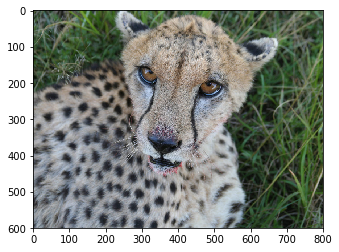

In [7]:
plt.figure()
plt.imshow(original.astype('uint8'))
plt.show()

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    print(img.shape)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    img = vgg16.preprocess_input(img)
    print(img.shape)
    return img

In [9]:
x = preprocess_image(image_path)

(600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)


In [10]:
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    img = img[:, :, ::-1] # BGR -> RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

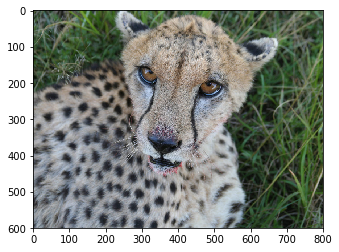

In [11]:
plt.figure()
plt.imshow(deprocess_image(x))
plt.show()

In [12]:
model_layers = {l.name:l for l in model.layers}
model_layers

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7fdd3f106b50>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7fdd3f106bd0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7fdd3dc76450>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7fdd3dbf4dd0>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7fdd3dbb3a90>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7fdd3dc76050>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7fdd3db7ff90>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7fdd3db86890>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7fdd3da9fb90>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7fdd3da80ed0>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7fdd3d9e8e90>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7fdd51a0a810>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7fdd3d891fd0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7fdd3d85051

In [13]:
layer_out = model_layers['block4_conv3'].output
layer_out1 = model_layers['block5_conv2'].output
layer_out.shape

Shape.0

In [14]:
loss = -K.mean(layer_out[:,:,:,0:100:10]) + (-K.mean(layer_out1[:,:,:,:10]))

# layer_out = model.output
# loss = -K.mean(layer_out[5])

In [15]:
gradients = K.gradients(loss, dream)
print(gradients)

outputs = [loss]
if isinstance(gradients, (list,tuple)):
    outputs += gradients
else:
    outputs.append(gradients)
    
f_outputs = K.function([dream], outputs)

InplaceDimShuffle{0,2,3,1}.0


In [16]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [17]:
settings = {
    'jitter': 0.8,
}

# fmin_l_bfgs_b?
all_loss = []

(600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
('Start of iteration', 0)
('Current loss value:', array(-62.1048, dtype=float32))


/home/munishgrover/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


('Image saved as', 'results/dream/im_at_iteration_0.png')
Iteration 0 completed in 135s
('Start of iteration', 1)
('Current loss value:', array(-129.7418, dtype=float32))
('Image saved as', 'results/dream/im_at_iteration_1.png')
Iteration 1 completed in 136s
('Start of iteration', 2)
('Current loss value:', array(-228.2265, dtype=float32))
('Image saved as', 'results/dream/im_at_iteration_2.png')
Iteration 2 completed in 135s
('Start of iteration', 3)
('Current loss value:', array(-341.50983, dtype=float32))
('Image saved as', 'results/dream/im_at_iteration_3.png')
Iteration 3 completed in 156s
('Start of iteration', 4)
('Current loss value:', array(-456.8695, dtype=float32))
('Image saved as', 'results/dream/im_at_iteration_4.png')
Iteration 4 completed in 150s
('Start of iteration', 5)
('Current loss value:', array(-578.5175, dtype=float32))
('Image saved as', 'results/dream/im_at_iteration_5.png')
Iteration 5 completed in 144s
('Start of iteration', 6)
('Current loss value:', array(

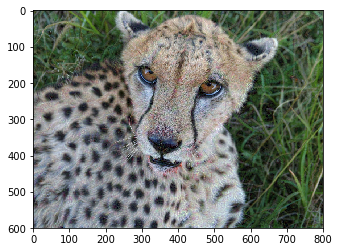

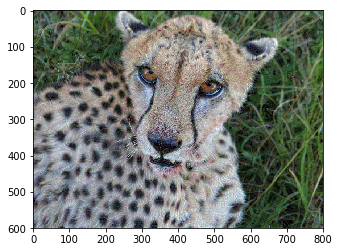

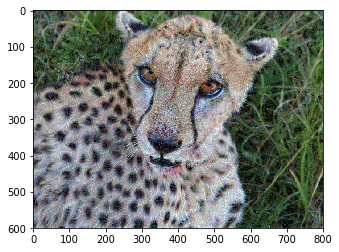

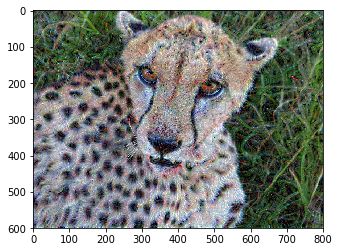

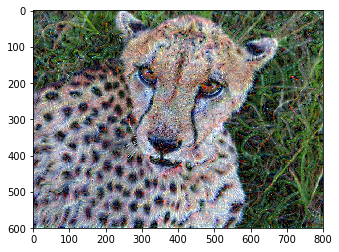

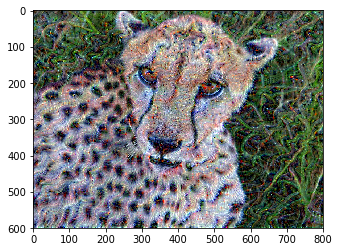

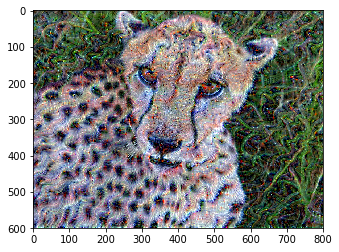

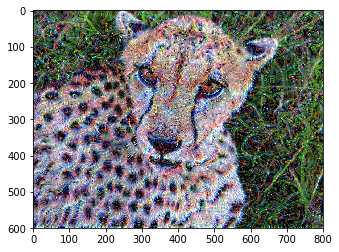

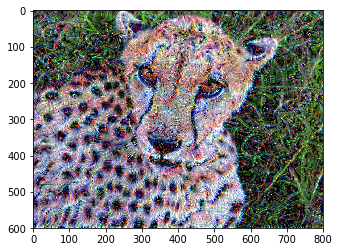

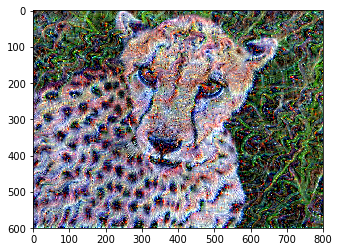

In [18]:
x = preprocess_image(image_path)
import time
for i in range(10):
    print ('Start of iteration', i)
    start_time = time.time()

    random_jitter = (settings['jitter'] * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter # Noise

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print ('Current loss value:', min_val)
    all_loss.append(min_val)
    
    # Decode the dream and save it
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess_image(np.copy(x))
    
    plt.figure(i)
    plt.imshow(img)
    
    fname = 'results/dream/im' + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
plt.show()